In [21]:
import pandas as pd
import gmaps as gp
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
properati = pd.read_csv('data/properati.csv')
len(properati)

121220

In [3]:
properati.columns

Index([u'id', u'created_on', u'operation', u'property_type', u'place_name',
       u'place_with_parent_names', u'country_name', u'state_name',
       u'geonames_id', u'lat-lon', u'lat', u'lon', u'price', u'currency',
       u'price_aprox_local_currency', u'price_aprox_usd',
       u'surface_total_in_m2', u'surface_covered_in_m2', u'price_usd_per_m2',
       u'price_per_m2', u'floor', u'rooms', u'expenses', u'properati_url',
       u'description', u'title', u'image_thumbnail'],
      dtype='object')

In [4]:
#Saco algunas columnas que no parecen servir
filtrado = properati.drop( ['id','operation','title','description','image_thumbnail','properati_url','property_type',
                            'country_name','state_name','place_name','lat-lon','geonames_id'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
filtrado.dropna(how='all',inplace=True)
filtrado.head(10)

,created_on,place_with_parent_names,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
0,2017-02-01,|Argentina|Capital Federal|Mataderos|,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.00,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN
1,2017-02-01,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,-34.903883,-57.964330,150000.0,USD,2646675.00,150000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-02-01,|Argentina|Capital Federal|Mataderos|,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.00,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN
3,2017-02-01,|Argentina|Capital Federal|Liniers|,-34.647797,-58.516424,95000.0,USD,1676227.50,95000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-01,|Argentina|Buenos Aires Costa Atlántica|Mar de...,-38.002626,-57.549447,64000.0,USD,1129248.00,64000.00,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN
5,2017-02-01,|Argentina|Entre Ríos|Gualeguaychú|,-33.014071,-58.519828,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2017-02-01,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,-34.532957,-58.521782,130000.0,USD,2293785.00,130000.00,106.0,78.0,1226.415094,1666.666667,NaN,NaN,NaN
7,2017-02-01,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.00,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN
8,2017-02-01,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.00,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN
9,2017-02-01,|Argentina|Santa Fe|Rosario|,-32.942031,-60.725919,460000.0,ARS,455201.45,25798.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#separo place_with_parent_names
separado = filtrado['place_with_parent_names'].apply(lambda x: pd.Series(x.split('|')))
# estaria bueno que las columnas tengan el nombre que corresponde y la 0 no tenga nombre
separado.columns = ['a','pais', 'region','localidad','ciudad','barrio','aborrar'] #mejorar
separado = separado.drop(['a','pais','aborrar'],1) # mejorar
separado.head(10)

,region,localidad,ciudad,barrio
0,Capital Federal,Mataderos,,NaN
1,Bs.As. G.B.A. Zona Sur,La Plata,,NaN
2,Capital Federal,Mataderos,,NaN
3,Capital Federal,Liniers,,NaN
4,Buenos Aires Costa Atlántica,Mar del Plata,Centro,
5,Entre Ríos,Gualeguaychú,,NaN
6,Bs.As. G.B.A. Zona Norte,Vicente López,Munro,
7,Capital Federal,Belgrano,,NaN
8,Capital Federal,Belgrano,,NaN
9,Santa Fe,Rosario,,NaN


In [6]:
#Uno las columnas nuevas en el set filtrado
filtrado = pd.concat([filtrado, separado], axis=1)
filtrado.drop('place_with_parent_names',1,inplace=True)

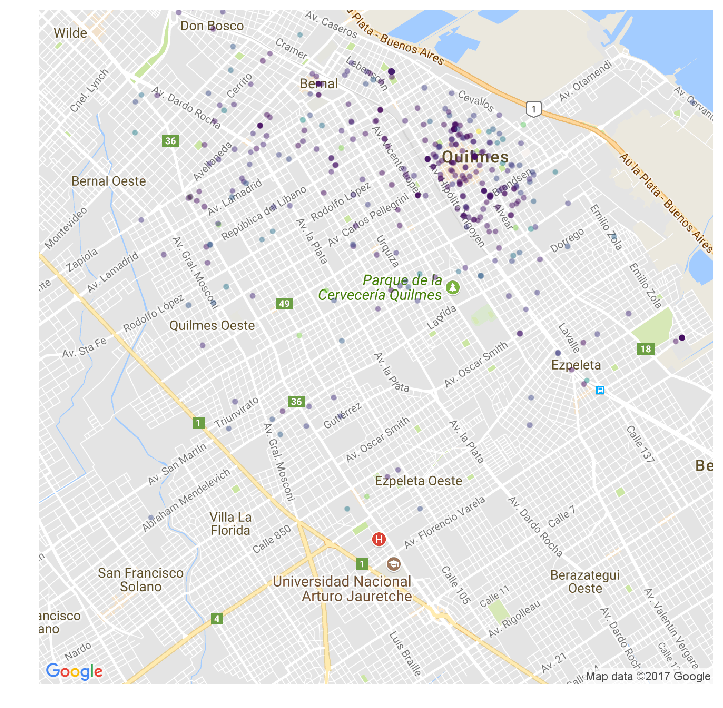

In [7]:
#solo para probar si funcionaba
cap=filtrado.loc[(filtrado['localidad'] == 'Quilmes')] 
gp.scatter(cap['lat'], cap['lon'],cap['surface_total_in_m2'])

In [8]:
propiedades_con_precio = filtrado.dropna(subset=['price'])  

In [59]:
ranking_precios = propiedades_con_precio.groupby('region').mean()['price_usd_per_m2'].sort_values(ascending=False)

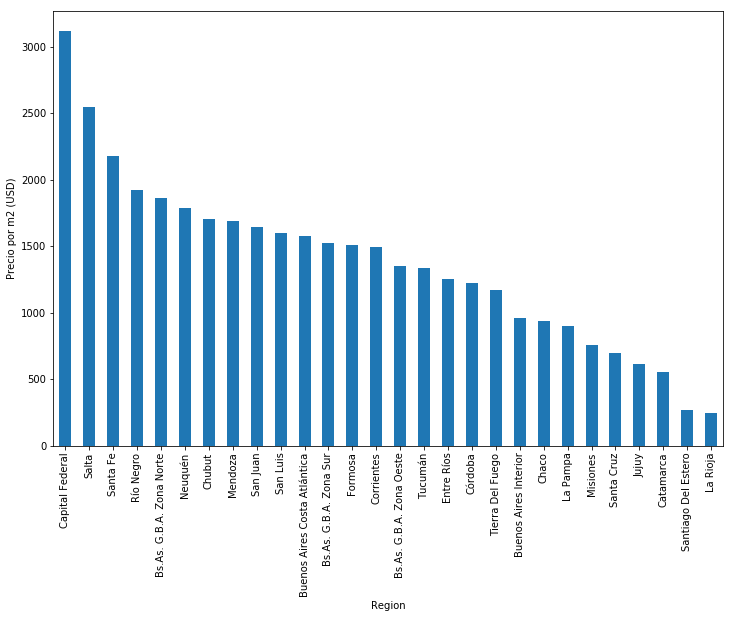

In [60]:
import matplotlib.pyplot as plt
ranking_precios.plot(kind='bar',figsize=(12,8))
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

#### salta en segundo lugar. Investigo por que

In [44]:
salta = propiedades_con_precio.loc[propiedades_con_precio['region'] == 'Salta'].sort_values('price_usd_per_m2',ascending = False)
salta

,created_on,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
25343,2017-04-28,-24.791039,-65.411225,2850000.0,USD,50286825.00,2850000.00,120.0,120.0,23750.000000,23750.000000,NaN,4.0,NaN,Salta,Salta,,NaN
26737,2017-04-28,-24.782439,-65.445556,2800000.0,USD,49404600.00,2800000.00,150.0,160.0,18666.666667,17500.000000,NaN,5.0,NaN,Salta,Salta,,NaN
25561,2017-04-28,-24.834989,-65.429807,1100000.0,USD,19408950.00,1100000.00,65.0,65.0,16923.076923,16923.076923,NaN,4.0,NaN,Salta,Salta,,NaN
26738,2017-04-28,-24.780039,-65.445389,2600000.0,USD,45875700.00,2600000.00,155.0,130.0,16774.193548,20000.000000,NaN,5.0,NaN,Salta,Salta,,NaN
25163,2017-04-28,-24.794442,-65.415589,2800000.0,USD,49404600.00,2800000.00,170.0,120.0,16470.588235,23333.333333,NaN,5.0,NaN,Salta,Salta,,NaN
26619,2017-04-28,-24.842185,-65.436251,2500000.0,USD,44111250.00,2500000.00,250.0,170.0,10000.000000,14705.882353,NaN,5.0,NaN,Salta,Salta,,NaN
99227,2017-07-19,NaN,NaN,1200000.0,USD,21173400.00,1200000.00,500.0,500.0,2400.000000,2400.000000,NaN,NaN,NaN,Salta,La Caldera,,NaN
78043,2017-07-19,NaN,NaN,250000.0,USD,4411125.00,250000.00,114.0,NaN,2192.982456,NaN,NaN,NaN,4100.0,Salta,,NaN,NaN
78143,2017-07-19,NaN,NaN,1500000.0,ARS,1484352.56,84125.51,44.0,44.0,1911.943409,34090.909091,NaN,NaN,NaN,Salta,,NaN,NaN
18497,2017-04-06,-24.789827,-65.428404,1686088.0,ARS,1668499.38,94562.01,51.0,51.0,1854.157059,33060.549020,NaN,NaN,NaN,Salta,Salta,,NaN


#### Las 6 primeras filas tienen precios altos en comparacion, tienen bien el precio?
La primer y la tercer fila tiene el mismo precio por m2 en pesos que en usd

La cuarta, quinta y la sexta tiene el precio en pesos mas alto que en dolares

Hay que filtrar todos esos casos

In [61]:
ranking_precios2 = propiedades_con_precio.groupby('region').mean()['price_per_m2'].sort_values(ascending=False)

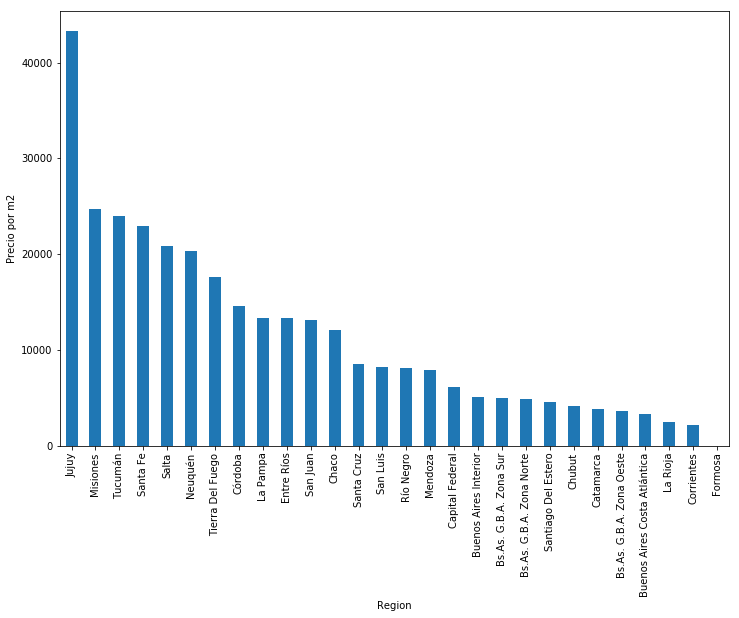

In [62]:
ranking_precios2.plot(kind='bar',figsize=(12,8))
plt.xlabel('Region')
plt.ylabel('Precio por m2')
plt.show()

#### Otra demostracion de los datos erroneos en los precios

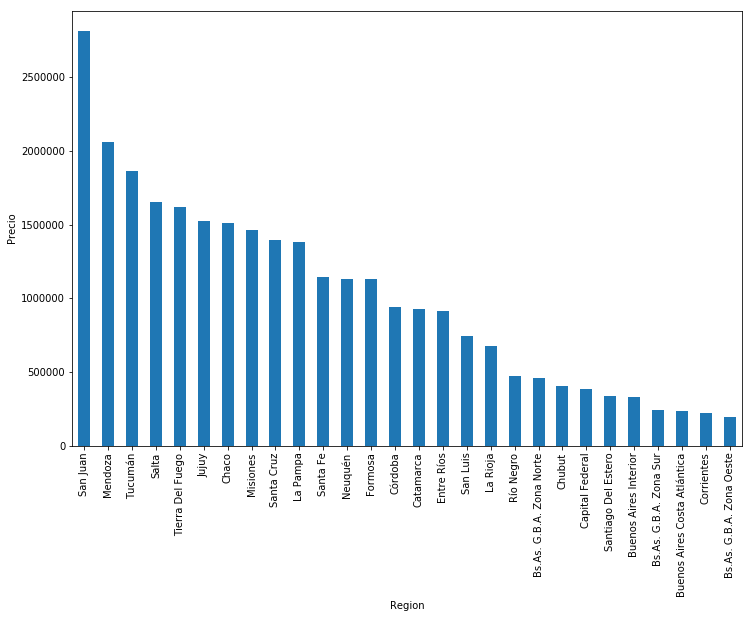

In [63]:
ranking_precios3 = propiedades_con_precio.groupby('region').mean()['price'].sort_values(ascending=False)
ranking_precios3.plot(kind='bar',figsize=(12,8))
plt.xlabel('Region')
plt.ylabel('Precio')
plt.show()

#### Otra demostracion de los datos erroneos en los precios